# TME Independant Cascade

In [1]:
import numpy as np
from collections import defaultdict

## Import données

In [2]:
trainFile = open("cascades_train.txt",'r')
episodes = []
for t in trainFile.readlines():
    l = []
    ep = np.array([e.split(":") for e in t[:-3].split(';')],float)
    ep = np.array(ep,int)
    episodes.append(ep[ep[:,1].argsort()])
    


In [3]:
episodes[1]

array([[97,  1],
       [26,  1],
       [74,  1],
       [36,  2],
       [95,  2],
       [42,  2],
       [ 7,  2],
       [ 6,  3],
       [72,  3],
       [47,  3],
       [48,  3],
       [52,  4],
       [63,  4],
       [60,  4],
       [17,  4],
       [68,  4],
       [40,  5],
       [ 8,  5],
       [37,  5],
       [62,  5],
       [79,  6],
       [90,  6],
       [73,  6],
       [30,  6],
       [57,  7],
       [11,  7],
       [65,  7],
       [54,  7],
       [75,  8],
       [20,  8],
       [ 3,  9],
       [82,  9],
       [99, 10],
       [70, 11]])

## Independant cascade

In [44]:
class IC():
    
    def __init__(self, delta=.001, maxEpochs=500):
        self.parents = defaultdict(dict)
        self.childs = defaultdict(dict)
        self.delta = delta
        self.maxEpochs = maxEpochs
        
    def createGraph(self,episodes):
        for e in episodes:
            childs = [e[e[:,1] > e[i,1]][:,0] for i in xrange(len(e))]
            for i,child in enumerate(childs):
                for s in child:
                    #random pour chaque liens
                    r = np.random.random() 
                    self.childs[e[i,0]][int(s)] = r
                    self.parents[int(s)][e[i,0]] = r
    
    
    def inference(self, s0):
        #print "calcul inference"
        infecte = defaultdict(bool)
        s = []
        s.append(s0)
        t = 1
        stop = False
        while s[t-1] != []:
            s.append([])
            for i in s[t-1]:
                for j in self.childs[i].keys():
                    if (not infecte[j]) and (np.random.random() < self.childs[i][j]):
                        infecte[j] = True
                        s[t].append(j)
            t = t + 1
        return s, infecte
    
    def apprentissage(self, episodes):
        self.episodes = episodes
        stop = False
        ite = 0
        self.scoresTable = []
        while not stop:
            
            p = {}
            
            for d,episode in enumerate(episodes):
                #nombre d'instants où il y a eu infection
                infections = np.unique(episode[:,1])
                #print infection
                utilisateurs = episode[:,0]
        
                #Calcul de PDtu(u)
                p[d] = np.zeros((len(infections),len(utilisateurs)))
                p[d][0,episode[:,1] == infections[0]] = 1
                
                for i in xrange(1,len(infections)):
                    for u,utilisateur in enumerate(utilisateurs):
                        hasparents = False
                        pdtu = 1.
                        tmp = episode[episode[:,1] < infections[i]][:,0]
                        for t in tmp:
                            if (t in self.parents[utilisateur]):
                                pdtu = pdtu * (1 - self.parents[utilisateur][t])
                                hasparents = True
                        if hasparents:
                            p[d][i,u] = 1-pdtu 
                        else:
                            p[d][i,u] = 1
    
            #Etape M 
            dmoins = np.zeros((len(self.parents), len(self.parents)))
            dplus  = np.zeros((len(self.parents), len(self.parents)))
            theta  = np.zeros((len(self.parents), len(self.parents)))
           
            for e,episode in enumerate(episodes):
                infections = list(np.unique(episode[:,1]))
                utilisateurs = episode[:,0]
                for u,uId in enumerate(utilisateurs):
                    dmoins[uId,:] = dmoins[uId,:] + 1
                    for v,vId in enumerate(utilisateurs):
                        
                        dmoins[uId, vId] = dmoins[uId, vId] - 1
                        if (episode[v,1] > episode[u,1]):
                            dplus[uId, vId] = dplus[uId, vId] + 1
                            tv = infections.index(episode[v,1])
                            theta[uId, vId] = theta[uId, vId] + (self.parents[vId][uId] / p[e][tv, v])
            theta = theta / (dplus + dmoins)
            for u in self.parents:
                for v in self.parents[u]:
                    self.parents[u][v] = theta[v,u]
                    self.childs[v][u] = theta[v,u]
                    
            # calcul du maximum à posteriori(scoire)
            logL = ite + 1
            s = self.score(episodes)
            if ite % 10 == 0:
                print ite,':',s
            self.scoresTable.append(s)
            if (ite != 0) and ((ite == self.maxEpochs) or (logL - prevLogL < self.delta)):
                stop = True
            ite = ite+1
            prevLogL = logL
            
    def predict(self, s0, nbEpochs=100):
        #print "calcul prediction"
        total_infecte = defaultdict(float)
        for i in xrange(nbEpochs):
            _, infecte = self.inference(s0)
            for j in infecte.keys():
                total_infecte[j] = total_infecte[j] + infecte[j]
        for j in xrange(len(total_infecte)):
            total_infecte[j] = total_infecte[j] / nbEpochs
        return total_infecte
    
    
    def score(self, episodes, nbEpochs=100):
        # print "calcul score"
        score = 0
        for ep in episodes:
            utilisateurs = ep[:,0]
            infections = np.unique(ep[:,1])
            sources = utilisateurs[[ep[:,1] == infections[0]]]
            prediction = self.predict(sources, nbEpochs)
            rang = np.array(prediction.keys())[(-np.array(prediction.values())).argsort()]
            scoreEp = 0
            compteur = 0.0
            for i,u in enumerate(rang):
                if u in utilisateurs:
                    compteur += 1.0
                    scoreEp += compteur / (i+1)
            score += scoreEp / len(utilisateurs)
        score = score / len(episodes)
        return score        
                

In [31]:
ic = IC(maxEpochs = 500)
ic.createGraph(episodes)

In [32]:
ic.apprentissage(episodes[1:5])

/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:87: RuntimeWarning: invalid value encountered in divide
/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


0 : 0.450313931147
100 : 0.790307729175
200 : 0.790307729175
300 : 0.790307729175
400 : 0.790307729175
500 : 0.790307729175


<function matplotlib.pyplot.show>

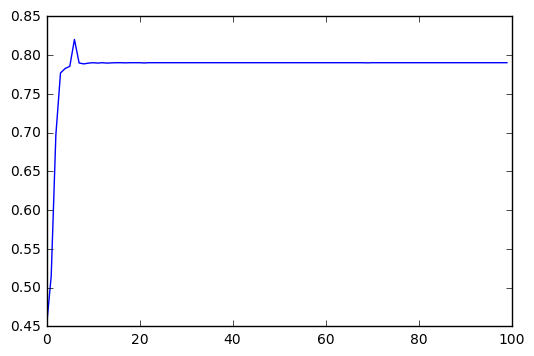

In [34]:
#score sur 3 épisodes
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(ic.scoresTable[:100])
plt.show

/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:87: RuntimeWarning: invalid value encountered in divide
/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


0 : 0.248235437052


<function matplotlib.pyplot.show>

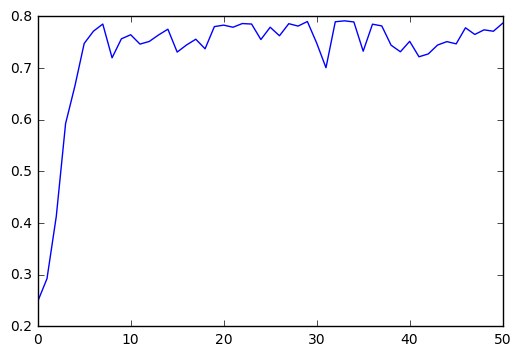

In [37]:
# epochs semblent suffisantes
ic = IC(maxEpochs = 50)
ic.createGraph(episodes)
ic.apprentissage(episodes[1:10])
plt.plot(ic.scoresTable)
plt.show

/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:87: RuntimeWarning: invalid value encountered in divide
/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


0 : 0.223741693305


<function matplotlib.pyplot.show>

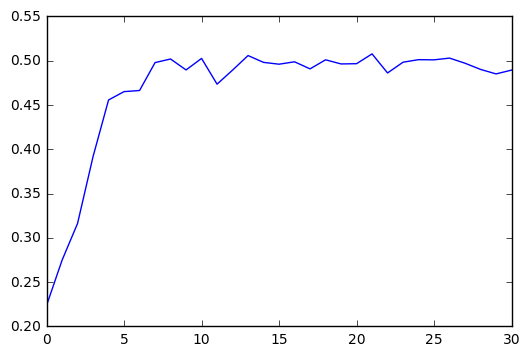

In [42]:
# epochs semblent suffisantes
ic = IC(maxEpochs = 30)
ic.createGraph(episodes)
ic.apprentissage(episodes[1:20])
plt.plot(ic.scoresTable)
plt.show

/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:87: RuntimeWarning: invalid value encountered in divide
/home/melki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


0 : 0.182273580876
10 : 0.299371489891
20 : 0.305107723034
30 : 0.306323821002
40 : 0.296069611814


<function matplotlib.pyplot.show>

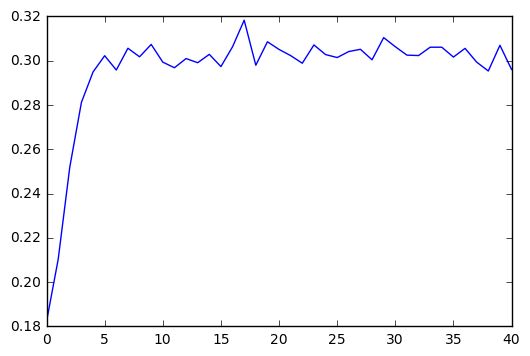

In [49]:
# epochs semblent suffisantes #(très long)
ic = IC(maxEpochs = 40)
ic.createGraph(episodes)
ic.apprentissage(episodes[1:99])
plt.plot(ic.scoresTable)
plt.show

In [ ]:
#convergence un peu naze